In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests
from scipy.cluster.hierarchy import linkage, leaves_list

In [2]:
# PARAMETERS
run_id="group_loops.09.19.ldcts"

In [3]:
# Parameters
run_id = "abc-group.12.23.ldcts"

In [5]:
selected_traits = {
    "Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_" : "Alzheimers Disease and Dementia", 
    "Nalls.LancetNeurol.2019.Parkinsons_disease_" : "Parkinson's Disease", 
    "PGC.Nature.2014.Schizophrenia_" : "Schizophrenia", 
    "Wray.biorxiv.2018.Major_Depressive_Disorder_" : "Major Depressive Disorder", 
    "Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_" : "ADHD", 
    "Mullins.NatGenet.2021.Bipolar_Disorder_" : "Bipolar Disorder", 
    "Grove.NatGenet.2019.Autism_Spectrum_Disorder_" : "Autism Spectrum Disorder", 
    "Jansen.2019.NatGenet.Insomnia_" : "Insomnia", 
    "PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_" : "Obsessive Compulsive Disorder", 
    "Deary.MolPsychiatry.2017.Tiredness_" : "Tiredness", 
    "IMSGC.Science.2019.Multiple_sclerosis_" : "Multiple Sclerosis", 
    "Luciano.NatGenet.2017.Neuroticism_" : "Neuroticism", 
    "Okbay.Nature.2016.Educational_Attainment_" : "Educational Attainment", 
    "Palmer.MolPsych.2021.problematic_opioid_use_" : "Problematic Opioid Use", 
    "Savage.NatGenet.2018.Intelligence_" : "Intelligence", 
    "vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_" : "Amyotrophic Lateral Sclerosis", 
    "Barban.NatGenet.2016.Age_First_Birth_" : "Age at First Birth", 
    "Chiou.Nature.2021.Type_1_diabetes_" : "Type 1 Diabetes", 
    "Watson.2018.NatGenet.Anorexia_Nervosa_" : "Anorexia Nervosa"
}

In [6]:
ldsc_results=f'/anvil/projects/x-mcb130189/rwang22/bican/ldsc/output/{run_id}'
directory = Path(ldsc_results)
dfs = {}

for file in directory.glob(f'*.cell_type_results.txt'):
    cur = pd.read_csv(file, sep = "\t")
    stripped = file.stem.replace(f'_.cell_type_results', "")
    cur["Trait"] = stripped
    dfs[stripped] = cur

In [7]:
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df["-log10(pval)"] = -np.log10(combined_df["Coefficient_P_value"])
combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")
combined_df = combined_df[combined_df["Trait"].isin(selected_traits.keys())] # only predetermined selected traits
combined_df.head()

/tmp/ipykernel_3276835/638502812.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")


,Name,Coefficient,Coefficient_std_error,Coefficient_P_value,Trait,-log10(pval)
440,GPi_Core,1.040074e-07,3.143834e-08,0.000469,Deary.MolPsychiatry.2017.Tiredness_,3.328526
441,VTR-HTH_Glut,1.049856e-07,3.176767e-08,0.000475,Deary.MolPsychiatry.2017.Tiredness_,3.323093
442,GPe-NDB-SI_LHX6-LHX8-GBX1_GABA,7.465705e-08,2.496947e-08,0.001395,Deary.MolPsychiatry.2017.Tiredness_,2.855366
443,BF_SKOR1_Glut,8.034902e-08,2.895343e-08,0.002759,Deary.MolPsychiatry.2017.Tiredness_,2.559228
444,STR_SST-RSPO2_GABA,7.047533e-08,2.695356e-08,0.004465,Deary.MolPsychiatry.2017.Tiredness_,2.350143


In [8]:
# Perform FDR correction using Benjamini-Hochberg procedure
rejected, q_values, _, _ = multipletests(combined_df["Coefficient_P_value"], alpha=0.05, method='fdr_bh')
combined_df["FDR_BH_corrected"] = q_values

In [9]:
# calculate the FDR p value threshold 
# https://www.r-bloggers.com/2023/07/the-benjamini-hochberg-procedure-fdr-and-p-value-adjusted-explained/

def fdr_bh_adj(df):
    tmp = combined_df.copy()
    tmp["rank"] =  combined_df['Coefficient_P_value'].rank()
    num_tests = len(tmp)
    tmp["adj_pval"] = (num_tests * tmp["Coefficient_P_value"]) / tmp["rank"]

    return tmp


In [10]:
tmp = fdr_bh_adj(combined_df)
# Align indices before comparison
fdr_bh_corrected = combined_df["FDR_BH_corrected"]
adj_pval = tmp["adj_pval"]

print(fdr_bh_corrected.sort_values())

4005    0.000019
3389    0.000019
3388    0.000019
3608    0.000019
3609    0.000019
          ...   
1231    0.999919
1230    0.999919
5059    0.999919
5224    0.999919
5323    0.999919
Name: FDR_BH_corrected, Length: 836, dtype: float64


In [11]:
print(adj_pval.sort_values())

3389    0.000019
3608    0.000019
4005    0.000020
3564    0.000020
3388    0.000023
          ...   
1229    1.007348
5223    1.007536
5058    1.007747
5057    1.007982
1231    1.008574
Name: adj_pval, Length: 836, dtype: float64


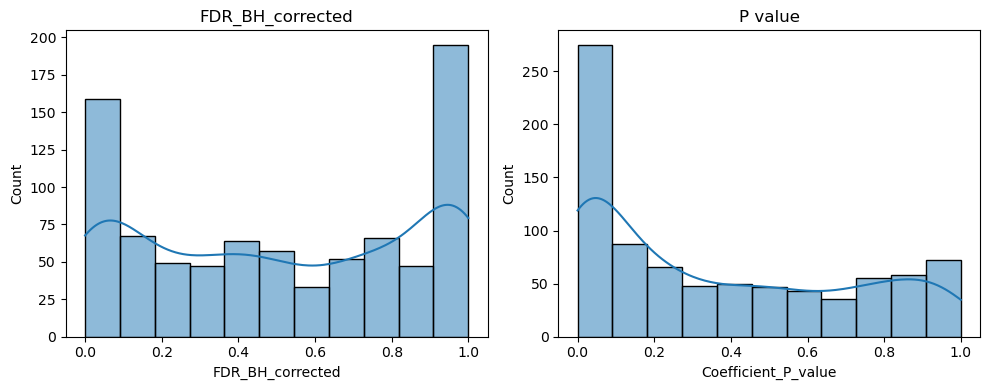

In [12]:
# plot the distribution of p values 
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First plot
sns.histplot(combined_df["FDR_BH_corrected"], kde=True, ax=axes[0])
axes[0].set_title("FDR_BH_corrected")

# Second plot
sns.histplot(combined_df["Coefficient_P_value"], kde=True, ax=axes[1])
axes[1].set_title("P value")

plt.tight_layout()
plt.show()

In [13]:
modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', 'FDR_BH_corrected'], axis=1)
modified_df = modified_df.pivot(index="Name", columns="Trait", values="-log10(pval)").reset_index()
modified_df = modified_df.set_index("Name")
modified_df.head()

Trait,Barban.NatGenet.2016.Age_First_Birth_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,Chiou.Nature.2021.Type_1_diabetes_,Deary.MolPsychiatry.2017.Tiredness_,Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_,Grove.NatGenet.2019.Autism_Spectrum_Disorder_,IMSGC.Science.2019.Multiple_sclerosis_,Jansen.2019.NatGenet.Insomnia_,Luciano.NatGenet.2017.Neuroticism_,Mullins.NatGenet.2021.Bipolar_Disorder_,Nalls.LancetNeurol.2019.Parkinsons_disease_,Okbay.Nature.2016.Educational_Attainment_,PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_,PGC.Nature.2014.Schizophrenia_,Palmer.MolPsych.2021.problematic_opioid_use_,Savage.NatGenet.2018.Intelligence_,Watson.2018.NatGenet.Anorexia_Nervosa_,Wray.biorxiv.2018.Major_Depressive_Disorder_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_
Name,,,,,,,,,,,,,,,,,,,
AMY-SLEA-BNST_GABA,1.024485,0.244589,0.030514,0.882120,1.419391,0.550343,0.060786,1.327803,2.840595,2.784559,1.605696,3.638643,0.106737,2.302862,0.220068,2.567662,1.078518,0.415992,0.689223
BF_SKOR1_Glut,3.906060,0.207929,0.065033,2.559228,1.663037,1.009895,0.010403,1.485342,3.200824,1.630162,2.383597,1.669164,0.406703,0.695459,0.829048,3.506112,0.430657,1.595589,0.141018
Endo,0.737734,0.773988,0.064261,0.237402,0.384729,0.200898,0.382517,0.086497,0.130728,0.001244,0.543375,0.023634,0.301941,0.001370,0.678740,0.338263,0.126185,0.003974,0.582937
GPe-NDB-SI_LHX6-LHX8-GBX1_GABA,1.154386,0.134826,0.006531,2.855366,0.814184,0.783940,0.010784,1.870108,3.048172,1.004649,2.245102,0.267375,0.707140,1.033287,0.101202,3.530555,0.648258,0.874742,0.297767
GPe_MEIS2-SOX6_GABA,1.729320,0.493313,0.101942,1.157468,0.699783,1.313343,0.036618,1.094782,1.894551,2.789605,0.755621,3.319373,0.200742,4.029689,0.076085,5.539528,0.834649,0.443382,0.255337


In [14]:
fdr_modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', '-log10(pval)'], axis=1)
fdr_modified_df = fdr_modified_df.pivot(index="Name", columns="Trait", values="FDR_BH_corrected").reset_index()
fdr_modified_df = fdr_modified_df.set_index("Name")
fdr_modified_df.head()

Trait,Barban.NatGenet.2016.Age_First_Birth_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,Chiou.Nature.2021.Type_1_diabetes_,Deary.MolPsychiatry.2017.Tiredness_,Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_,Grove.NatGenet.2019.Autism_Spectrum_Disorder_,IMSGC.Science.2019.Multiple_sclerosis_,Jansen.2019.NatGenet.Insomnia_,Luciano.NatGenet.2017.Neuroticism_,Mullins.NatGenet.2021.Bipolar_Disorder_,Nalls.LancetNeurol.2019.Parkinsons_disease_,Okbay.Nature.2016.Educational_Attainment_,PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_,PGC.Nature.2014.Schizophrenia_,Palmer.MolPsych.2021.problematic_opioid_use_,Savage.NatGenet.2018.Intelligence_,Watson.2018.NatGenet.Anorexia_Nervosa_,Wray.biorxiv.2018.Major_Depressive_Disorder_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_
Name,,,,,,,,,,,,,,,,,,,
AMY-SLEA-BNST_GABA,0.282204,0.810922,0.996664,0.350382,0.150148,0.542468,0.982173,0.175451,0.014152,0.015345,0.115786,0.003099,0.946218,0.035883,0.840323,0.023322,0.259380,0.657347,0.446462
BF_SKOR1_Glut,0.001879,0.853257,0.981481,0.023537,0.104381,0.288752,0.999919,0.140949,0.007115,0.110680,0.031421,0.104381,0.664931,0.441249,0.373267,0.003950,0.647462,0.115922,0.929555
Endo,0.420117,0.399646,0.981481,0.814737,0.686710,0.857622,0.688845,0.966872,0.934615,0.999919,0.543343,0.999919,0.758357,0.999919,0.453815,0.726623,0.935933,0.999919,0.516210
GPe-NDB-SI_LHX6-LHX8-GBX1_GABA,0.234088,0.933810,0.999919,0.014053,0.381666,0.397366,0.999919,0.078986,0.009717,0.290210,0.039293,0.789651,0.436394,0.279537,0.952839,0.003791,0.475720,0.350782,0.758833
GPe_MEIS2-SOX6_GABA,0.096804,0.586638,0.952588,0.233635,0.440141,0.179786,0.996265,0.255501,0.076199,0.015345,0.407645,0.005565,0.857622,0.001531,0.973126,0.000104,0.372978,0.632728,0.804100


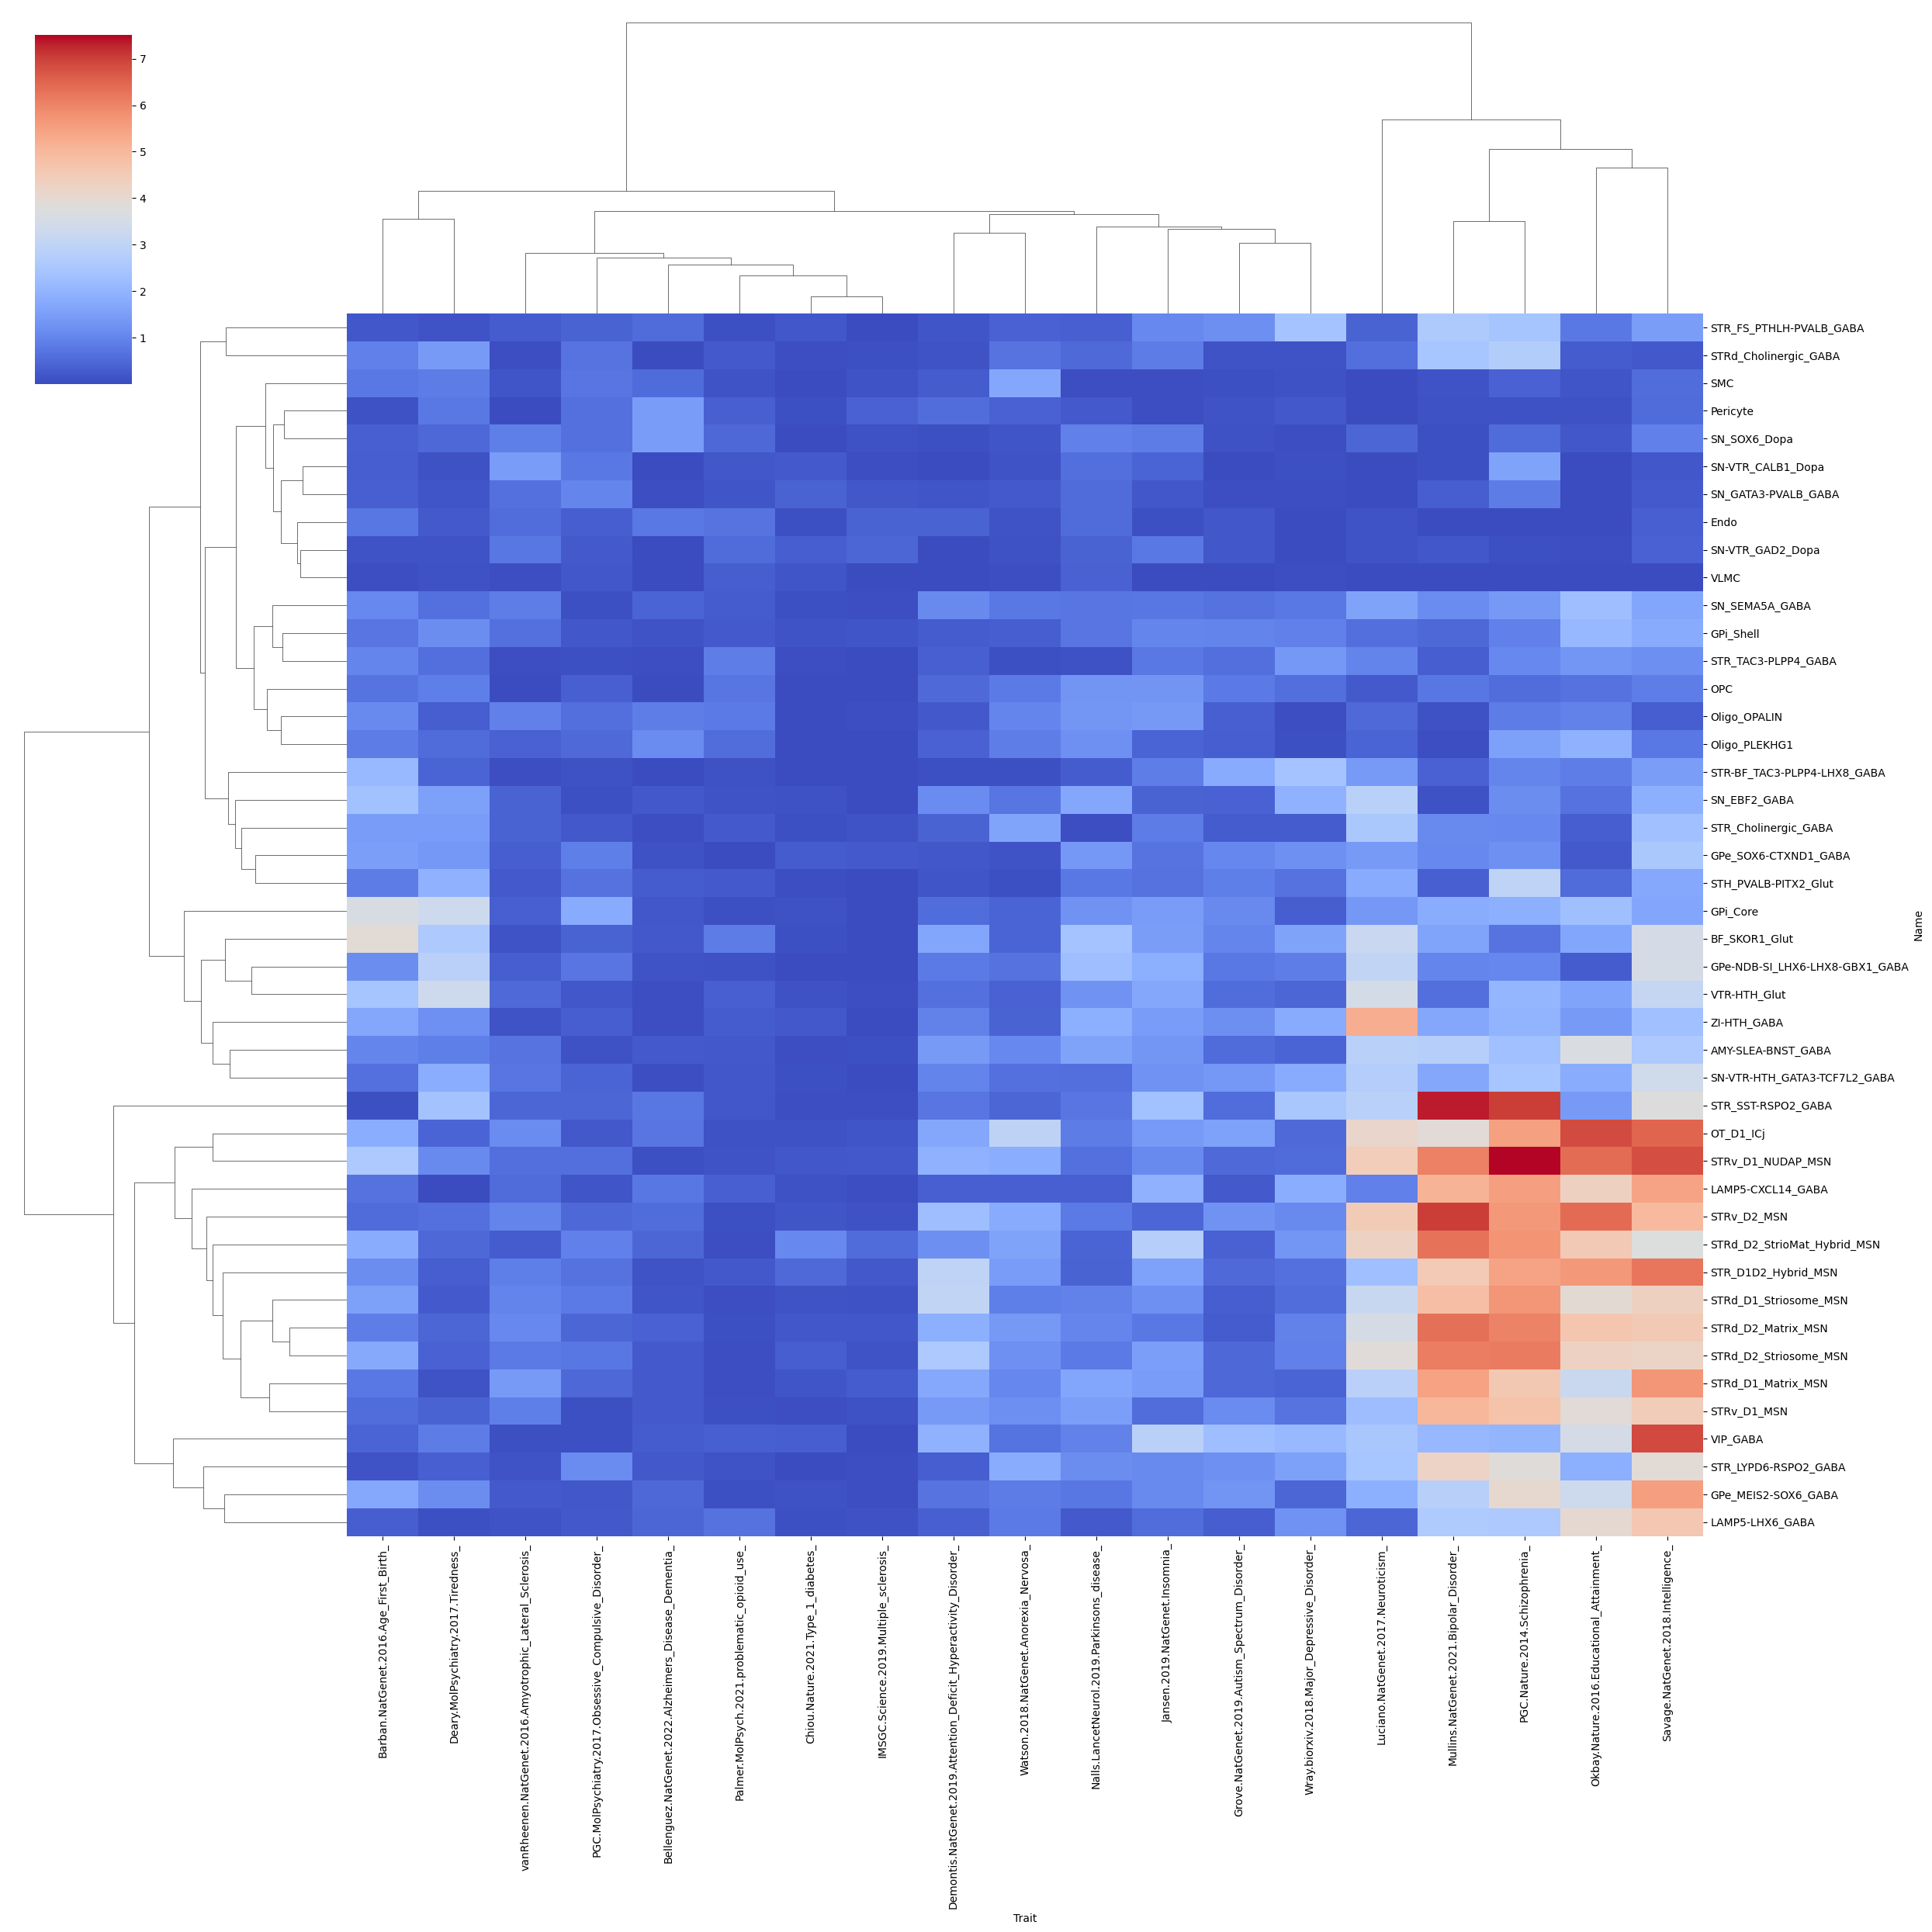

In [14]:
g = sns.clustermap(modified_df, cmap='coolwarm', figsize=(25, 25))

plt.show()
g.savefig(f'output/{run_id}_filtered.pdf')

In [15]:
def pval_to_star(p):
    if p < 1e-7:
        return '***'
    elif p < 1e-5:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

In [16]:
# Cluster rows
linkage_rows = linkage(modified_df.values, method="average", metric="euclidean")
row_order = leaves_list(linkage_rows)

# Cluster columns
linkage_cols = linkage(modified_df.values.T, method="average", metric="euclidean")
col_order = leaves_list(linkage_cols)

modified_df = modified_df.iloc[row_order, col_order].rename(columns = selected_traits)
fdr_modified_df = fdr_modified_df.iloc[row_order, col_order].rename(columns = selected_traits)

In [17]:
fdr_modified_df = fdr_modified_df.reindex(
    index=modified_df.index,    # same row order as df
    columns=modified_df.columns # same column order as df
)

In [18]:
cols_to_keep = fdr_modified_df.loc[:, (fdr_modified_df < 0.05).any()].columns
cols_to_keep

Index(['Age at First Birth', 'Tiredness', 'ADHD', 'Anorexia Nervosa',
       'Parkinson's Disease', 'Insomnia', 'Autism Spectrum Disorder',
       'Major Depressive Disorder', 'Neuroticism', 'Bipolar Disorder',
       'Schizophrenia', 'Educational Attainment', 'Intelligence'],
      dtype='object', name='Trait')

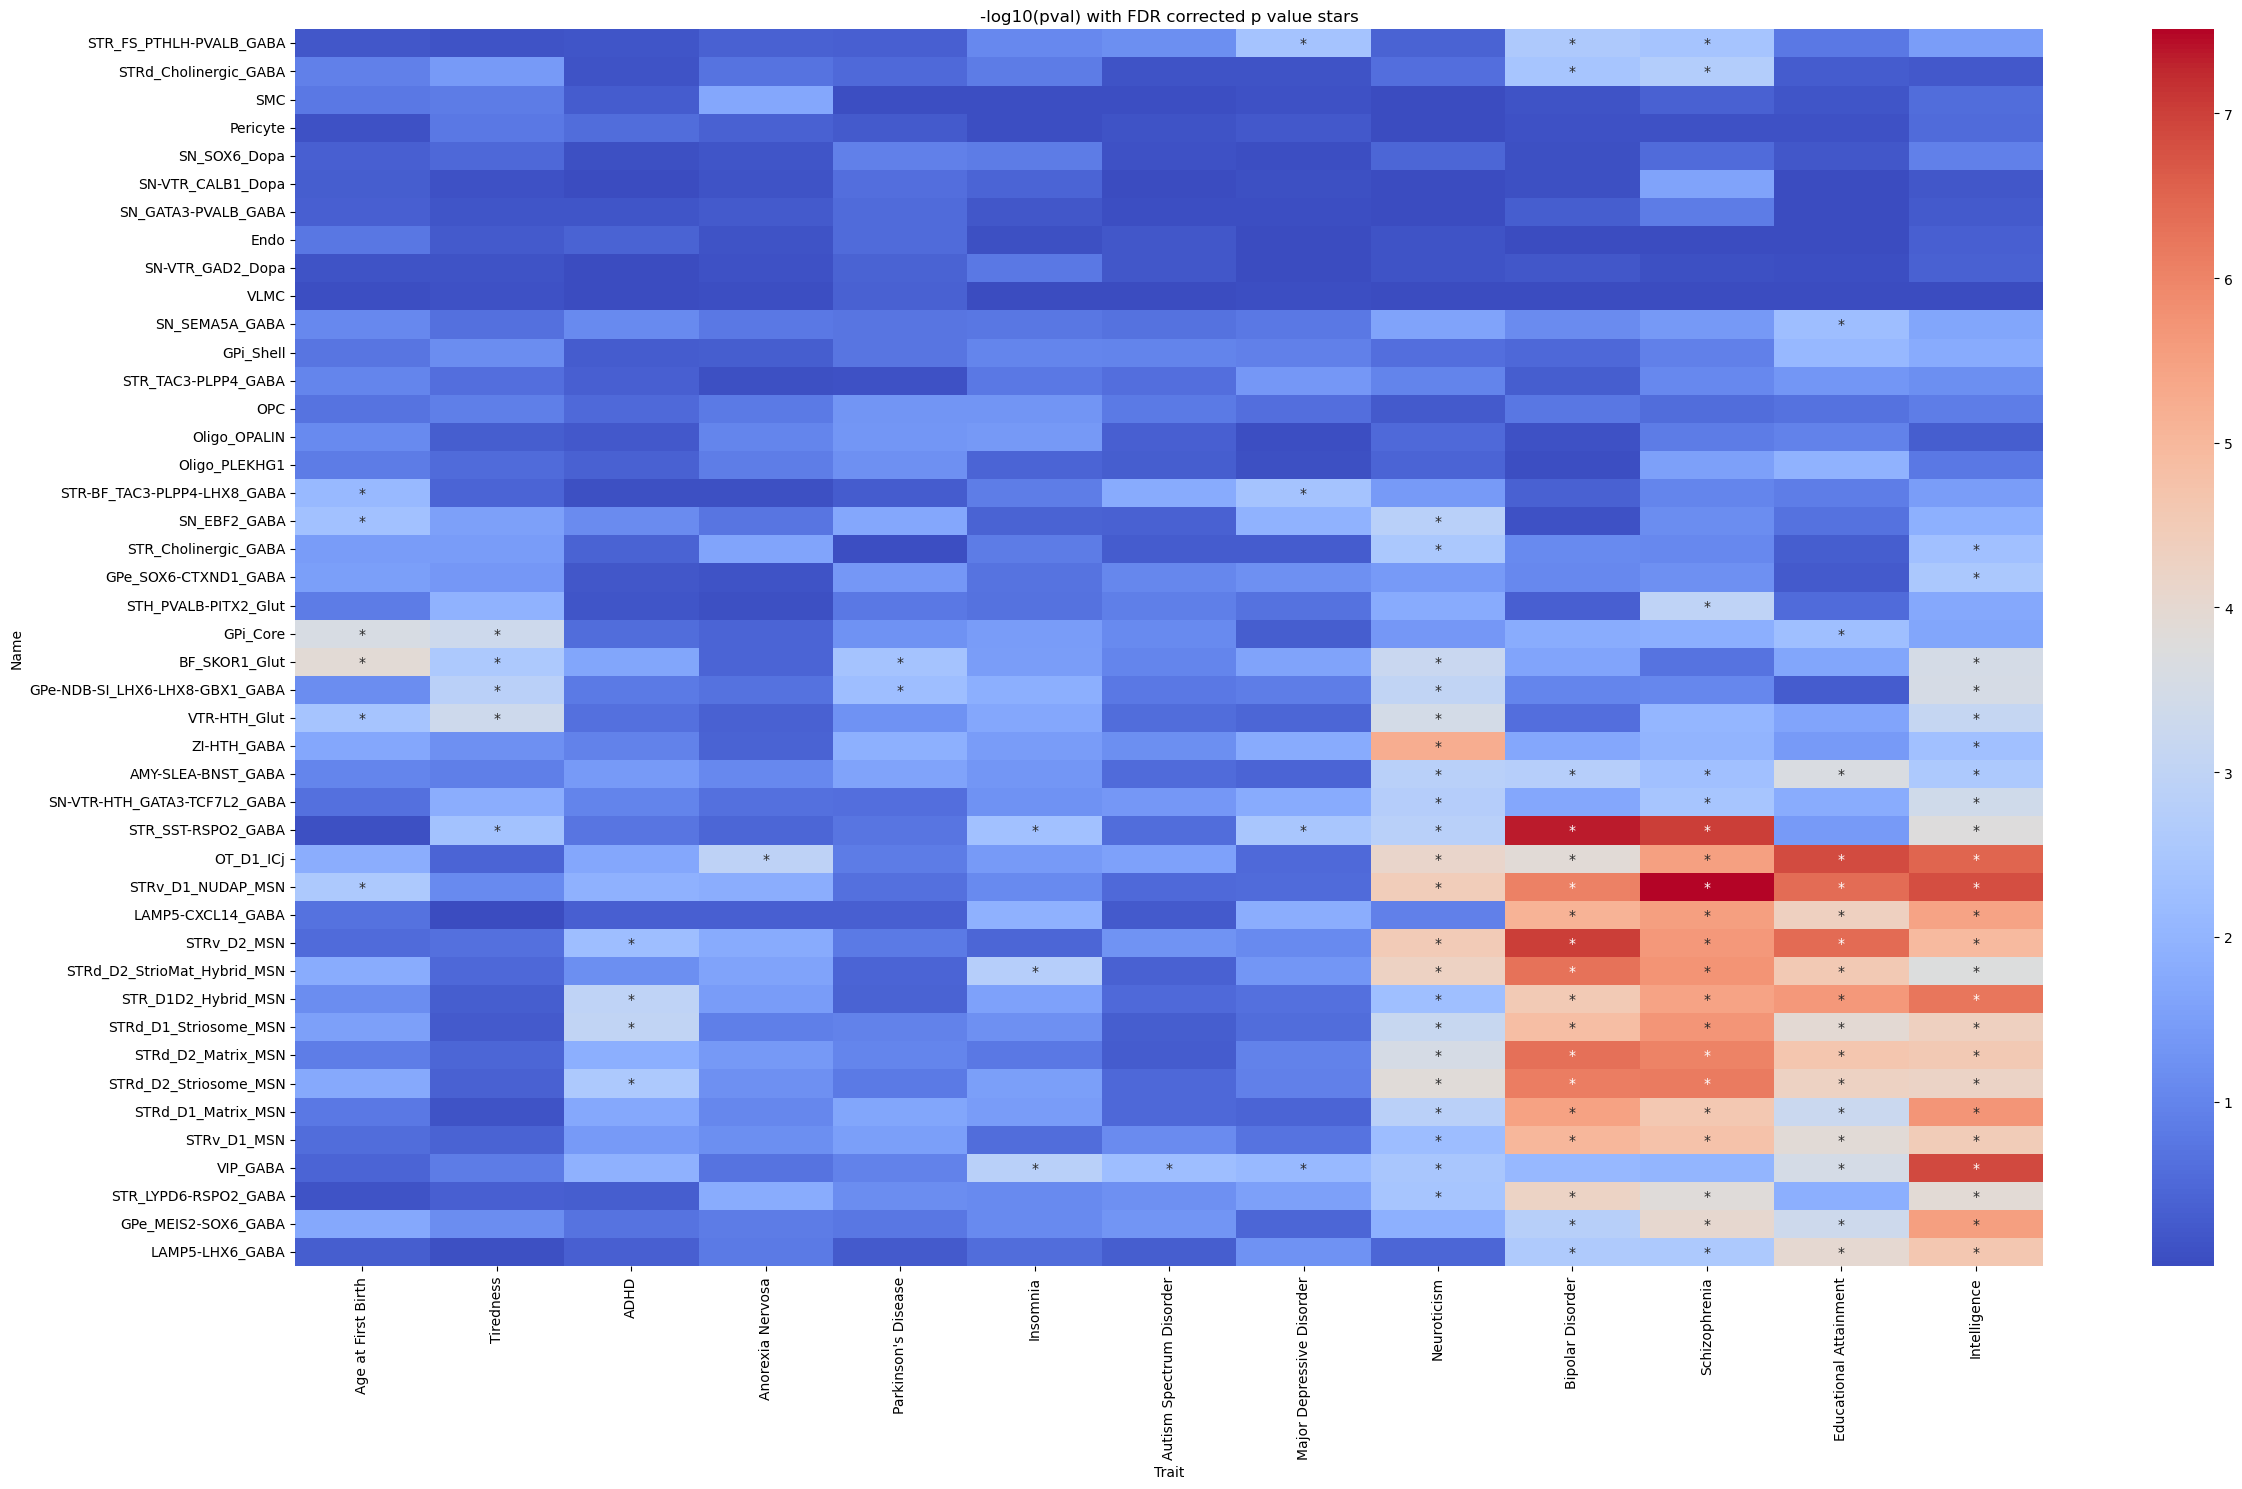

In [20]:
if len(cols_to_keep) > 0:
    stars = fdr_modified_df[cols_to_keep].applymap(pval_to_star)

    # Plot heatmap with annotations
    plt.figure(figsize=(25, 15))
    sns.heatmap(modified_df[cols_to_keep], annot=stars, fmt='', cmap='coolwarm')
    plt.title("-log10(pval) with FDR corrected p value stars")
    plt.tight_layout()
    # plt.savefig(f'output/{run_id}_filtered_FDR_corrected.pdf')
    plt.show()
else:
    # Plot heatmap with annotations
    plt.figure(figsize=(16, 8))
    sns.heatmap(modified_df, fmt='', cmap='coolwarm')
    plt.title("-log10(pval) with raw p value")
    plt.tight_layout()
    plt.savefig(f'output/{run_id}_filtered_raw_pval.pdf')
    plt.show()

In [28]:
import os
metadata = pd.read_csv(os.path.expanduser("/anvil/projects/x-mcb130189/Wubin/BG/clustering/100kb/annotations.tsv"),sep='\t',index_col=0)
keep_cells=metadata.loc[~ (metadata['Group'].isin(['doublet','Glut','Unk','Low quality cells']))].index.tolist() #,
metadata=metadata.loc[keep_cells]
df_cols = metadata.loc[:,['Group','Class','Neighborhood']].drop_duplicates().set_index('Group')
df_cols.sort_values(['Neighborhood','Class','Group'],inplace=True)
df_cols.head()

,Class,Neighborhood
Group,,
BF SKOR1 Glut,F M Glut,Glut Sero Dopa
STH PVALB-PITX2 Glut,F M Glut,Glut Sero Dopa
VTR-HTH Glut,F M Glut,Glut Sero Dopa
SN SOX6 Dopa,M Dopa,Glut Sero Dopa
SN-VTR CALB1 Dopa,M Dopa,Glut Sero Dopa


In [29]:
import matplotlib as mpl
mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi']=300

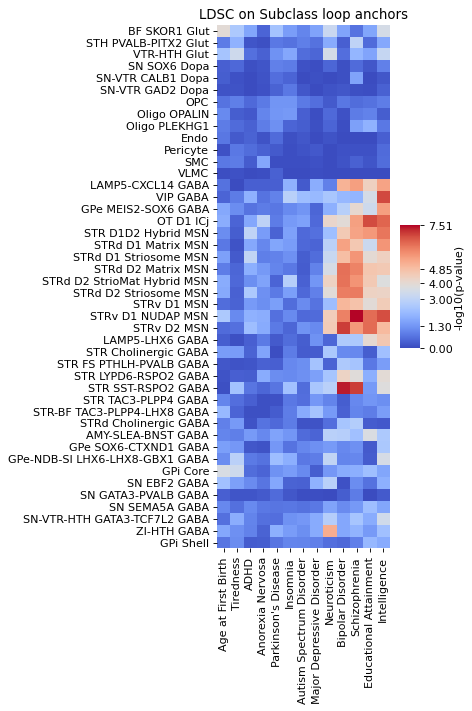

In [30]:
# Plot heatmap with annotations
import os

modified_df.index=modified_df.index.to_series().apply(lambda x:x.replace('_',' '))
fdr_modified_df.index=fdr_modified_df.index.to_series().apply(lambda x:x.replace('_',' '))

row_order=[ct for ct in df_cols.index.tolist() if ct in modified_df.index.tolist()]
vmax=modified_df.loc[row_order,cols_to_keep].max().max()

fig, ax = plt.subplots(figsize=(6, 9))
ax=sns.heatmap(modified_df.loc[row_order,cols_to_keep], #annot=fdr_modified_df.loc[row_order,cols_to_keep].applymap(pval_to_star), 
               fmt='', cmap='coolwarm',cbar_kws={'shrink': 0.4,'fraction':0.1,'aspect':6},
               annot_kws=dict(ha='center',va='center'),#vmin=0,vmax=4.85,cbar=False
              ax=ax)
# plt.title("-log10(pval) with FDR corrected p value stars")
ax.set_title("LDSC on Subclass loop anchors")
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
cbar = ax.collections[0].colorbar
cbar.set_label("-log10(p-value)", fontsize=10, labelpad=1)
cbar.set_ticks([0,1.3,3,4,4.85,vmax])
plt.tight_layout()
plt.savefig(f'{run_id}_fig.pdf')
# plt.savefig(os.path.expanduser("~/Projects/BG/pseudobulk/DMR/LDSC_plots/Group_loops.pdf"),transparent=True,bbox_inches='tight',dpi=300)
plt.show()